In [19]:
import scipy.io as io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

%matplotlib inline

In [4]:
oc = io.loadmat('C:\computer_harddrive\comprehensive\data.mat')
oc = oc['data']
oc['chl'][0,0][:,0]
var = ['chl','sst','sal','o2','n2']
oc

array([[ (array([[ 0.        ],
       [ 0.        ],
       [ 0.        ],
       ..., 
       [ 0.81151502],
       [ 0.83193322],
       [ 0.        ]]), array([[ 12.77935],
       [ 12.55875],
       [ 12.69875],
       ..., 
       [  9.59105],
       [  9.58385],
       [  0.     ]]), array([[ 28.50465],
       [ 28.6138 ],
       [ 27.86385],
       ..., 
       [ 29.5641 ],
       [ 29.5906 ],
       [  0.     ]]), array([[ 6.20093 ],
       [ 6.22677 ],
       [ 6.240555],
       ..., 
       [ 6.59803 ],
       [ 6.597705],
       [ 0.      ]]), array([[ 11.285145],
       [ 11.32728 ],
       [ 11.358505],
       ..., 
       [ 11.93195 ],
       [ 11.93107 ],
       [  0.      ]]), array([[ 228.8  ],
       [ 228.802],
       [ 228.804],
       ..., 
       [ 153.625],
       [ 153.627],
       [ 153.629]]))]],
      dtype=[('chl', 'O'), ('sst', 'O'), ('sal', 'O'), ('o2', 'O'), ('n2', 'O'), ('new_time', 'O')])

In [5]:
def parse_df(oc,var):
    df = pd.DataFrame(index=oc['new_time'][0,0][:,0])
    for v in var:
        df[v]=oc[v][0,0][:,0]
    return df

#### resample into space grid ###

In [4]:
def resample_space(df,var,x,y,lat,lon):
    thre = 0.05
#     data = np.zeros(x.shape)
#     data_std = np.zeros(x.shape)
    df_resample = pd.DataFrame()
    df_resample_std = pd.DataFrame()
    for v in var:
        data = np.zeros(x.size)
        data_std = np.zeros(x.size)
        for i in np.arange(x.size):
            row = int(np.floor(i/x.shape[1]))
            columns = int(i - row*x.shape[1] - 1)
            index = (np.abs(x[row,columns]-lon)<thre) & (np.abs(y[row,columns]-lat)<thre)
            if len(df[v].ix[index]) >0 :
                #print(len(df[v].ix[index]))
                data[i] = np.nanmean(df[v].ix[index])
                data_std[i] = np.nanstd(df[v].ix[index])
        df_resample[v]=data
        df_resample_std[v]=data
    return df_resample, df_resample_std

In [5]:
def plot_map(chl):
    chl = np.reshape(chl,x.shape)
    chl[chl==0]=['nan']
    data = np.ma.masked_where(np.isnan(chl),chl)
    plt.pcolormesh(x,y,data)
    plt.colorbar() 
    plt.show()

#### main function to resample and plot ####

In [6]:
X = np.linspace(-150,-120,360)
Y = np.linspace(45,60,180)

x,y = np.meshgrid(X,Y)
lat = oc['lat'][0,0][:,0]
lon = oc['lon'][0,0][:,0]

df = parse_df(oc,var)
#df_re, df_re_std = resample_space(df,var,x,y,lat,lon)


ValueError: no field of name lat

In [6]:
#plot_map(df_re['micro'])
df = parse_df(oc,var)
df = df.replace(0, np.nan)
df = df.dropna()
df.head()

,chl,sst,sal,o2,n2
228.976,0.003932,11.7637,30.53165,6.255530,11.352350
228.986,6.022768,11.7935,30.51650,6.252245,11.347095
228.988,6.105478,11.7792,30.51360,6.254470,11.350820
228.990,6.176207,11.7768,30.48675,6.255640,11.353120
229.002,20.371076,12.1132,30.53040,6.209570,11.276150


#### effective no to compare is 464, after removing ipar>100 ####
#### 844 in total ####

In [11]:
newdf=pd.DataFrame()
df_re = df_re.dropna()
cols = ['ipar','fv_fm','mld','sal','sst']
log_cols = ['chl','fluo']
newdf[log_cols]=np.log10(df_re[log_cols])
newdf[cols]=df_re[cols]
newdf=newdf[newdf['ipar']>100]
newdf= newdf.dropna()
#len(df)
newdf

NameError: name 'df_re' is not defined

#### heatmap

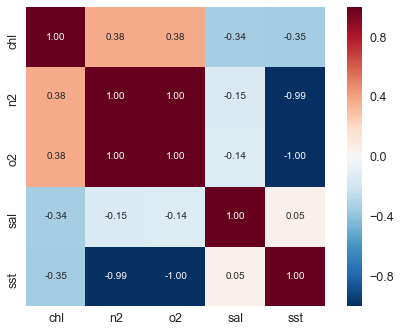

In [61]:
#saleprice correlation matrix
k = 5 #number of variables for heatmap
corrmat = df.corr()
cols = corrmat.nlargest(k, 'chl')['chl'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', 
                 annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

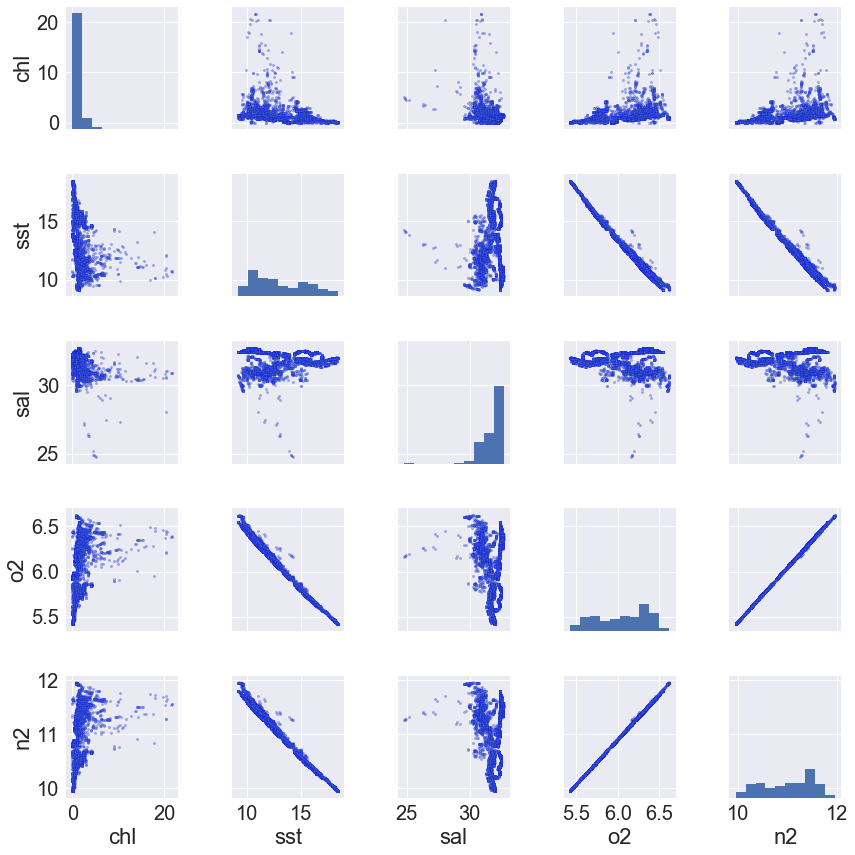

In [12]:
#scatterplot
sns.set(font_scale=2)
sns.pairplot(df, plot_kws=dict(s=5, edgecolor="b", alpha=0.5))
plt.show();

#### model regression ####

In [ ]:
key = ['ipar','fluo','sst','sal','fv_fm','mld']
y = df['chl']
x = df[key]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [ ]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, x_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

([array([    0.,  1946.,  2773.,  1916.,  1073.,     0.,     0.,     0.,
             0.,     0.]),
  array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,    10.,
            54.,  7644.]),
  array([ 7708.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.]),
  array([    0.,  3193.,  4515.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.])],
 array([  5.42121 ,   8.150449,  10.879688,  13.608927,  16.338166,
         19.067405,  21.796644,  24.525883,  27.255122,  29.984361,  32.7136  ]),
 <a list of 4 Lists of Patches objects>)

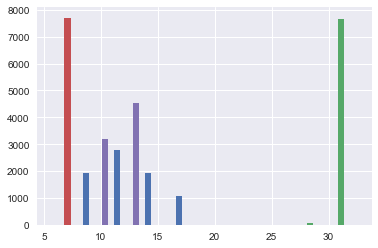

In [28]:
plt.hist(X)

In [24]:
from sklearn.linear_model import Lasso


x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.3)

model_lasso = Lasso().fit(x_train, y_train)
predictions = model_lasso.predict(x_test)
print(r2_score(y_test,predictions), mean_absolute_error(y_test,predictions))
# #let's look at the residuals as well:
# plt.rcParams['figure.figsize'] = (6.0, 6.0)

# preds = pd.DataFrame({"preds":model_lasso.predict(x_test), "true":y_test})
# preds["residuals"] = preds["true"] - preds["preds"]
# preds.plot(x = "preds", y = "residuals",kind = "scatter")

#plt.plot(model_lasso.coef_, color='gold', linewidth=2,
         #label='Lasso coefficients')
#plt.legend(loc='best')
# plt.title("Lasso R^2: %f, Elastic Net R^2: %f"
#           % (r2_score_lasso, r2_score_enet))
#plt.show()

0.0486878819135 0.728126759406


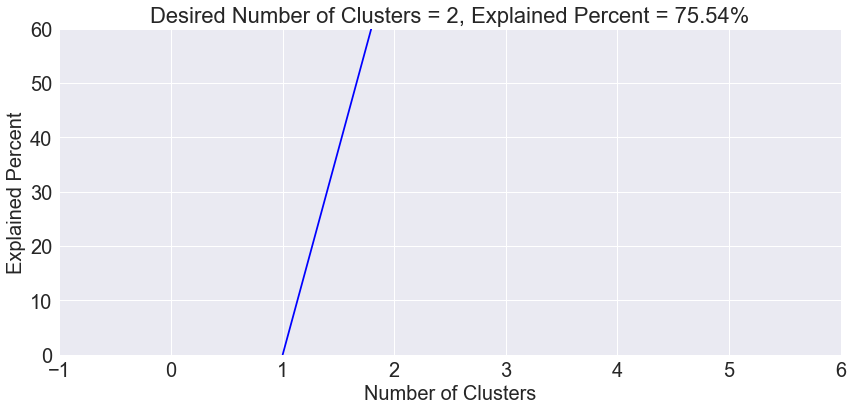

In [63]:
from sklearn import cluster, decomposition, preprocessing
#%% we now finally have a numeric representation of the dataset and we are ready to cluster the users
listOfNumClusters = [1,2,3,4,5]
listOfInertia = []
for numClusters in listOfNumClusters:
    KMeansModel = cluster.MiniBatchKMeans(n_clusters=numClusters, batch_size=2100, n_init=5, random_state=1)
    KMeansModel.fit(newdf)
    listOfInertia.append(KMeansModel.inertia_)
explainedPercent = 100*(1-(np.array(listOfInertia)/listOfInertia[0]))

# plot the explained percent as a function of number of clusters
percentExplainedTarget = 40

numDesiredClusterInd = np.nonzero(explainedPercent > percentExplainedTarget)[0][0]
numDesiredClusters = listOfNumClusters[numDesiredClusterInd]

explainedPercentReached = explainedPercent[numDesiredClusterInd]
plt.figure(figsize=(14,6)); plt.plot(listOfNumClusters,explainedPercent,c='b')
plt.scatter(numDesiredClusters,explainedPercentReached,s=150,c='r')
plt.xlabel('Number of Clusters', fontsize=20); plt.ylabel('Explained Percent', fontsize=20)
plt.title('Desired Number of Clusters = %d, Explained Percent = %.2f%s' %(numDesiredClusters,explainedPercentReached,'%'),fontsize=22);
plt.xlim(-1,listOfNumClusters[-1]+1); plt.ylim(0,60);

### model for regression in random forest 

In [48]:
df.reset_index().head(2)

,index,chl,sst,sal,o2,n2
0,228.976,0.003932,11.7637,30.53165,6.255530,11.352350
1,228.986,6.022768,11.7935,30.51650,6.252245,11.347095


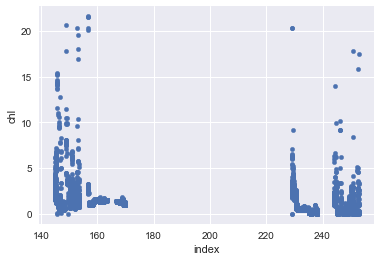

In [49]:
df.reset_index().plot(x='index', y='chl', kind='scatter')

In [41]:
# Build a classification task using 3 informative features
X=df.iloc[:,1:].values
y=df['chl'].values

# x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.3)
x_train, x_test = X[:5000], X[5000:]
y_train, y_test = y[:5000], y[5000:]
# Build a forest and compute the feature importances
forest = RandomForestRegressor(n_estimators=250,
                              random_state=0)

forest.fit(x_train, y_train)

# get the feature importance
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

In [42]:
# get the score
predictions = forest.predict(x_test)
print(r2_score(y_test,predictions), mean_absolute_error(y_test,predictions))

-0.717604282644 1.45075257431


(0, 2)

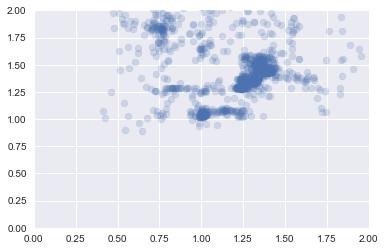

In [43]:
plt.scatter(y_test, predictions, alpha=0.2)
plt.xlim(0, 2)
plt.ylim(0, 2)

(array([  4.77400000e+03,   4.73000000e+02,   7.60000000e+01,
          3.30000000e+01,   1.30000000e+01,   4.00000000e+00,
          6.00000000e+00,   5.00000000e+00,   3.00000000e+00,
          8.00000000e+00]),
 array([  5.39369885e-05,   2.16165017e+00,   4.32324641e+00,
          6.48484264e+00,   8.64643888e+00,   1.08080351e+01,
          1.29696314e+01,   1.51312276e+01,   1.72928238e+01,
          1.94544201e+01,   2.16160163e+01]),
 <a list of 10 Patch objects>)

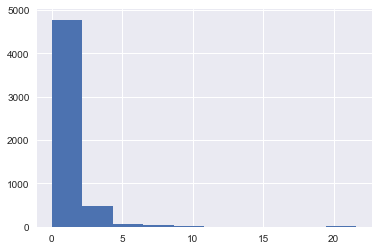

In [37]:
plt.hist(y_train)

In [13]:
# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

array([  3.93238387e-03,   6.02276771e+00,   6.10547787e+00, ...,
         8.23263749e-01,   8.11515018e-01,   8.31933220e-01])